In [1]:
!curl -O 'https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip'
!unzip -q 'Audio_Speech_Actors_01-24.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0   575k      0  0:05:53  0:05:53 --:--:--  576k


In [2]:
from IPython.display import Audio

In [3]:
Audio('Actor_01/03-01-03-01-01-01-01.wav') #happyの声

In [4]:
Audio('Actor_01/03-01-05-01-01-01-01.wav') #angryの声

In [5]:
!pip install librosa

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import librosa
from torch.nn.utils import rnn

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

files = [
    'Actor_*/03-01-01-*.wav',
    'Actor_*/03-01-02-*.wav',
    'Actor_*/03-01-03-*.wav',
    'Actor_*/03-01-04-*.wav',
    'Actor_*/03-01-05-*.wav',
    'Actor_*/03-01-06-*.wav',
    'Actor_*/03-01-07-*.wav',
    'Actor_*/03-01-08-*.wav',
]

dataset = []
label = []
for i, f in enumerate(files):
    for wav in glob.glob(f):
        audio_data, sr = librosa.load(wav)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr)
        dataset.append(torch.tensor(mfccs.T, dtype=torch.float))
        label.append(torch.tensor(i))

dataset = rnn.pad_sequence(dataset, batch_first=True) #最大フレームに合わせて0埋めしてくれる（シーケンス長をそろえる）
dataset = dataset.numpy() #numpyにする（いろいろやりやすいように）
label = np.array(label)

In [ ]:
print(dataset.shape) #[1440のサンプルから構成, 1サンプルは228フレームのMFCC特徴量を持つ, 各フレームは20次元の特徴を持つ]
print(label)
print(dataset)

(1440, 228, 20)
[0 0 0 ... 7 7 7]
[[[-9.68915039e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-9.68619385e+02  4.17970657e-01  4.17875290e-01 ...  4.08938736e-01
    4.07844633e-01  4.06691015e-01]
  [-9.67667908e+02  1.62882602e+00  1.33064330e+00 ...  9.89838123e-01
    1.17839646e+00  1.43380642e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-7.38537903e+02  1.17848648e+02  1.62146130e+01 ...  3.56955266e+00
    3.36916256e+00  4.47356319e+00]
  [-7.88926392e+02  1.03907875e+02  2.62194691e+01 ...  4.68608093e+00
    5.09814787e+00  6.63196802e+00]
  [-8.80847290e+02  4.85582619e+01  3.88983345e+01 ...  5.59467983e+00
    7.78392839e+00  9.56954384e

In [ ]:
#データを分ける
train_data, test_data, train_label, test_label = train_test_split(dataset, label, test_size=0.2, random_state=2)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(train_data[0])

(1152, 228, 20)
(288, 228, 20)
(1152,)
[[-763.0558       0.           0.        ...    0.           0.
     0.       ]
 [-762.2492       1.1406794    1.1404216 ...    1.1160305    1.113047
     1.1098961]
 [-761.193        2.63396      2.6327183 ...    2.5171132    2.503239
     2.4886472]
 ...
 [   0.           0.           0.        ...    0.           0.
     0.       ]
 [   0.           0.           0.        ...    0.           0.
     0.       ]
 [   0.           0.           0.        ...    0.           0.
     0.       ]]


In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 180
        #特徴量20個で、隠れ層180個、バッチサイズは最初に入力（この方がやりやすい（体感））
        self.lstm = nn.LSTM(input_size=20, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, 8) #出力を8個にする（感情の数）

    def forward(self, x):
        x, _ = self.lstm(x) #(hidden_state, cell_state)はいらないのでoutputだけ取る
        x_last = x[:, -1, :] #シーケンスの最後の値を取る（時系列なので最後が大事）
        x = self.linear(x_last)
        return x

model = LSTM()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_avg_history = []
test_accuracy_history = []

In [ ]:
def calc_accuracy(X, Y):
    acc = 0
    cnt = 0
    for x, y in zip(X, Y):
        x = torch.tensor(x, dtype=torch.float)
        x = x.to(device)
        y = torch.tensor(y, dtype=torch.long)
        y = y.to(device)
        pred = model(x.unsqueeze(0)) #unsqueezeでバッチ次元を追加しバッチサイズを1にする
        _, predicted = torch.max(pred.data, dim=1) #predictedに最大値のインデックスを取得（ _ は最大値）
        if predicted == y: #インデックスの値が目的変数と一緒だったら正解
            acc += 1
        cnt += 1
    return acc / cnt

In [ ]:
def train(epochs):
    print('Start Training...')
    for epoch in range(epochs):
        loss_sum = 0
        for x, y in zip(train_data, train_label):
            x = torch.tensor(x, dtype=torch.float)
            x = x.to(device)
            y = torch.tensor(y, dtype=torch.long)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(x.unsqueeze(0))
            loss = criterion(pred, y.unsqueeze(0))
            loss_sum += loss.item()
            loss.backward()
            optimizer.step()

        loss_avg = loss_sum / len(train_data)
        test_accuracy = calc_accuracy(test_data, test_label)
        print(f'{epoch} | train_Loss = {loss_avg} | test_Accuracy = {test_accuracy}')
        loss_avg_history.append(loss_avg)
        test_accuracy_history.append(test_accuracy)
    print('Done.')

In [ ]:
train(50)

Start Training...
0 | train_Loss = 2.071006331075397 | test_Accuracy = 0.13541666666666666
1 | train_Loss = 2.074724309715546 | test_Accuracy = 0.13541666666666666
2 | train_Loss = 2.0622578083227077 | test_Accuracy = 0.13194444444444445
3 | train_Loss = 2.0274592879642217 | test_Accuracy = 0.1875
4 | train_Loss = 1.9856515291871295 | test_Accuracy = 0.22569444444444445
5 | train_Loss = 1.9479452215859459 | test_Accuracy = 0.2013888888888889
6 | train_Loss = 1.8857804424543347 | test_Accuracy = 0.20833333333333334
7 | train_Loss = 1.824514235654432 | test_Accuracy = 0.2222222222222222
8 | train_Loss = 1.776814273920738 | test_Accuracy = 0.2777777777777778
9 | train_Loss = 1.6752520575602021 | test_Accuracy = 0.3541666666666667
10 | train_Loss = 1.6218182026382744 | test_Accuracy = 0.3506944444444444
11 | train_Loss = 1.5360831072256487 | test_Accuracy = 0.375
12 | train_Loss = 1.5287796937239666 | test_Accuracy = 0.3888888888888889
13 | train_Loss = 1.490612360726421 | test_Accuracy = 

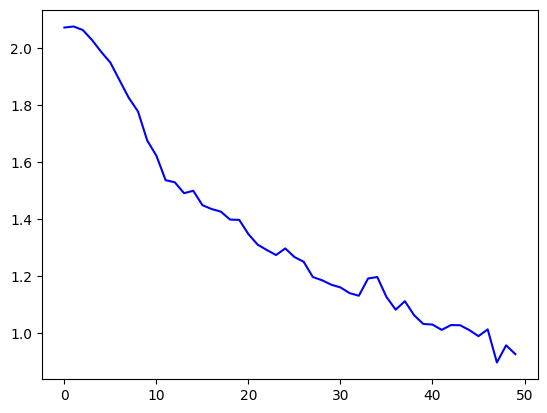

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
plt.plot(loss_avg_history, color='blue')

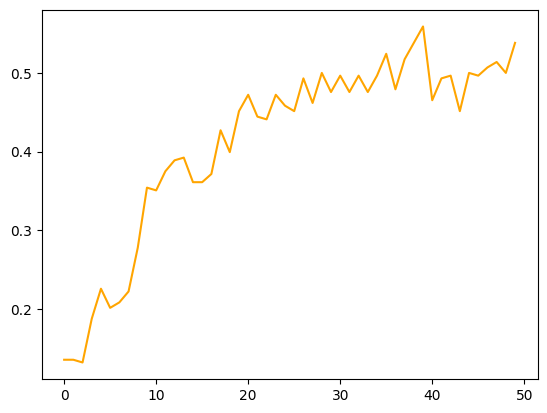

In [ ]:
plt.plot(test_accuracy_history, color='orange')

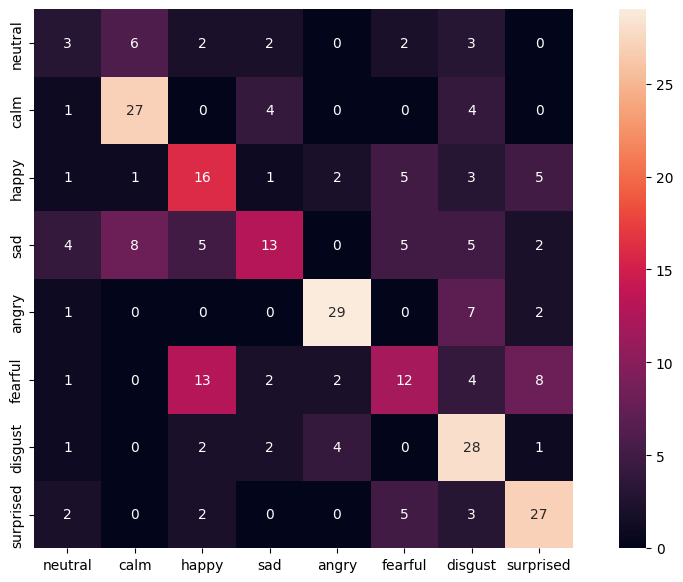

In [ ]:
import pandas as pd
emotionCategory = {"neutral": 0, "calm": 1, "happy": 2,
"sad": 3, "angry": 4,"fearful": 5, "disgust": 6,
"surprised": 7}
x = torch.tensor(test_data, dtype=torch.float)
predict_classes = model(x).cpu().detach().numpy().argmax(-1)
cmx_data = confusion_matrix(test_label.reshape(-1), predict_classes)
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize = (12,7))
sn.heatmap(df_cmx, annot=True, fmt='g' ,square = True,yticklabels=emotionCategory,xticklabels=emotionCategory)
plt.show()